## **Modelo 2**

### Imaginemos que en el [primer modelo](https://github.com/rcruzgar/prediccion_clientes/blob/main/Modelo_Clientes.ipynb) se ha producido un *data leakage*, debido a que los teléfonos móviles correspondían en su mayoría a clientes ya contratados realmente. Vamos a crear otro algoritmo para predecir el estado final de los clientes sin utilizar los teléfonos como variables predictoras.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

In [ ]:
df = pd.read_excel('/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/data.xlsx',
                   index_col=None, header=21)
df.head()

,Telf1-3 Digitos,Telf1-1 Digitos,Telf2-3 Digitos,Telf2-1 Digitos,dir_cp,CIF primera letra,NOM,codigo tarifa,potencias_contratadas_en_w_p1,Consumo,codigo_empresa_distribuidora,codigo_tension_v,es_vivienda_habitual,Comercializadora,Estado final
0,936,9,NaN,NaN,8290,4,AARON,1,4600,2282.0,31,2,NaN,91.0,0
1,972,9,NaN,NaN,17497,4,Abalos,5,10392,5412.0,31,6,NaN,91.0,0
2,933,9,NaN,NaN,8042,4,ABDELHAMID,1,4400,2661.0,31,2,NaN,927.0,0
3,937,9,NaN,NaN,8380,4,ABDELKADAR,1,6900,3306.0,31,2,NaN,91.0,0
4,937,9,NaN,NaN,8760,4,ABDELLAH,1,4400,4351.0,31,2,NaN,91.0,0


In [ ]:
df.shape

(58510, 15)

### En este notebook nos podemos saltar el análisis exploratorio, aunque sí que eliminaremos algunos outliers para que el modelo final sea más generalizable.

Eliminamos **la primera letra del CIF** y si es **vivienda habitual**:

In [ ]:
df.drop(['CIF primera letra'], axis=1, inplace=True)

In [ ]:
df.drop(['es_vivienda_habitual'], axis=1, inplace=True)

Quitamos los valores *outliers* de **potencia contratada**:

In [ ]:
df = df[(df['potencias_contratadas_en_w_p1'] > 0) & (df['potencias_contratadas_en_w_p1'] < df['potencias_contratadas_en_w_p1'].quantile(0.999))]

También los *outliers* del **consumo anual**.

In [ ]:
print(df['Consumo'].isnull().sum())
df = df[pd.notnull(df['Consumo'])]

In [ ]:
df = df[(df['Consumo'] > 0) & (df['Consumo'] < df['Consumo'].quantile(0.999))]

Del **código de la comercializadora anterior** borramos las filas con valores nulos.

In [ ]:
print(df['Comercializadora'].isnull().sum())
df = df[pd.notnull(df['Comercializadora'])]

## **Creación del modelo predictivo**

### En esta sección diseñaremos varios modelos de Machine Learning para predecir la contratación de clientes en función de algunas de las variables proporcionadas inicialmente. 

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from time import time
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

Elegimos las variables predictoras que formarán parte de los modelos:

In [ ]:
features_list = ['codigo tarifa', 'potencias_contratadas_en_w_p1', 'Consumo',
                'codigo_empresa_distribuidora', 'codigo_tension_v', 'Comercializadora',
                 'dir_cp']

Como es un dataset muy desequilibrado (pocas contrataciones en comparación con las personas que no contratan al final), hay que aplicar una estratificación al dividir en *training* y *test*, para que la variable objetivo *Estado final* esté igual de representada en ambas particiones. De otra manera podríamos experimentar *oversampling* o *undersampling*. Realizamos un *cross validation* con 6 particiones para seleccionar los modelos con los que continuaremos:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features_list], df['Estado final'],
                                                    train_size=0.8, stratify = df['Estado final'],
                                                    random_state=3, shuffle=True)

Tenemos que escalar los datos, ya que vamos a elegir ciertos algoritmos que lo requieren, como SVM. Otros, como los Random Forests, no lo necesitan, pero el resultado sería el mismo. Elegimos el *MinMaxScaler*.

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
kfold = StratifiedKFold(n_splits=6, random_state=3, shuffle=True)

Inicializamos múltiples algoritmos, ya que no hay un modelo que funcione mejor para todas las situaciones. Así que hay que probar cuál da los mejores resultados.

In [ ]:
random_state = 3
model_list = []

# Ensemble Methods
model_list.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
model_list.append(ExtraTreesClassifier(random_state=random_state))
model_list.append(GradientBoostingClassifier(random_state=random_state))
model_list.append(RandomForestClassifier(random_state=random_state))

# GLM
model_list.append(LogisticRegression(random_state = random_state))

# Naives Bayes
model_list.append(GaussianNB())

# Nearest Neighbor
model_list.append(KNeighborsClassifier())

# SVM
model_list.append(SVC(random_state=random_state))

# xgboost
model_list.append(XGBClassifier())

In [ ]:
t0 = time()
cv_results = []
for model in model_list :
    cv_results.append(cross_val_score(model, X_train_scaled, y=y_train,
                                      scoring='f1', cv=kfold, n_jobs=4))

print('Tiempo total transcurrido: ', '%.3f'%(time() - t0) , 's')

Evaluamos los modelos con el F1-Score. Esta métrica es más adecuada que otras como la precisión, ya que la muestra está desequilibrada.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


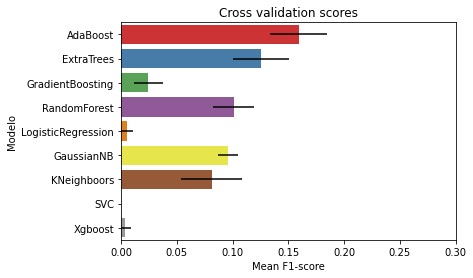

In [ ]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std,
                       'Modelo':['AdaBoost', 'ExtraTrees', 'GradientBoosting',
                       'RandomForest', 'LogisticRegression', 'GaussianNB',
                       'KNeighboors', 'SVC', 'Xgboost']})

g = sns.barplot('CrossValMeans', 'Modelo', data=cv_res, palette='Set1',
                 orient='h', **{'xerr':cv_std})
plt.xlim(0, 0.3)
g.set_xlabel('Mean F1-score')
g = g.set_title('Cross validation scores')

Elegiremos AdaBoost, ExtraTrees y RandomForest.

### **Hyperparameter tuning**

Usamos *Search grid* para elegir los parámetros más óptimos para cada algoritmo:

In [ ]:
features_list2 = ['codigo tarifa', 'potencias_contratadas_en_w_p1', 'Consumo',
                 'codigo_tension_v', 'Comercializadora', 'dir_cp']

X_train2, X_test2, y_train2, y_test2 = train_test_split(df[features_list2], df['Estado final'],
                                                    train_size=0.8, stratify = df['Estado final'],
                                                    random_state=3, shuffle=True)
kfold2 = StratifiedKFold(n_splits=6, random_state=3, shuffle=True)

y_train2.value_counts()

0    45341
1     1095
Name: Estado final, dtype: int64

Para equilibrar la representación de las dos clases a predecir (0 o no contrata y 1 o contrata), hay que recurrir primero a un *random under sampler*, para reducir el número de instancias de la clase mayoritaria, y posteriormente aumentar la clase minoritaria con un *random over sampler*:

In [ ]:
under = RandomUnderSampler(sampling_strategy=0.1)
X_rus, y_rus = under.fit_resample(X_train2, y_train2)
print(Counter(y_rus))

Counter({0: 10950, 1: 1095})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
over = RandomOverSampler(sampling_strategy=0.9)
X_combined_sampling, y_combined_sampling = over.fit_resample(X_rus, y_rus)
print(Counter(y_combined_sampling))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({0: 10950, 1: 9855})


Search Grid de los hiper-parámetros para los tres algoritmos:

In [ ]:
rf2 = RandomForestClassifier()
ab = AdaBoostClassifier(DecisionTreeClassifier(random_state=3, max_depth=6))
xt = ExtraTreesClassifier()

# Random Forests:
grid_search_rf2 = {'max_depth': [4, 6, 8, 10],
                  'max_features': [4, 5, 6],
                  'min_samples_split': [2, 3],
                  'min_samples_leaf': [1, 3],
                  'criterion': ['gini'],
                  'bootstrap': [False],
                  'n_estimators' :[200, 220, 250, 300],
                  'random_state': [3]}
# Ada Boost:
grid_search_ab = {'n_estimators': [200, 250, 300, 350],
                  'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]}

# Extra Trees
grid_search_xt = {'n_estimators': [100, 200, 250, 300],
                  'criterion': ['gini'],
                  'bootstrap': [False],
                  'max_depth': [6, 8, 10, 12],
                  'min_samples_split': [2, 3],
                  'min_samples_leaf': [1, 3],
                  'max_features': [3, 4, 5, 6]}

rf_gs2 = GridSearchCV(rf2, param_grid = grid_search_rf2, cv=kfold2, scoring='f1',
    n_jobs= -1, verbose = 1)

ab_gs = GridSearchCV(ab, param_grid = grid_search_ab, cv=kfold2, scoring='f1',
                     n_jobs= -1, verbose = 1)

xt_gs = GridSearchCV(xt, param_grid = grid_search_xt, cv=kfold2, scoring='f1',
                     n_jobs= -1, verbose = 1)

**Random Forests:**

In [ ]:
rf_gs2.fit(X_combined_sampling, y_combined_sampling)
from joblib import dump
rf_best2 = rf_gs2.best_estimator_
dump(rf_best2, '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/random_forests4.joblib')

Fitting 6 folds for each of 192 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 1152 out of 1152 | elapsed: 38.5min finished


['/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/random_forests4.joblib']

**Ada Boost:**

In [ ]:
ab_gs.fit(X_combined_sampling, y_combined_sampling)
ab_best = ab_gs.best_estimator_
dump(ab_best, '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/adaboost4.joblib') 

Fitting 6 folds for each of 28 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  9.2min finished


['/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/adaboost4.joblib']

**Extra Trees:**

In [ ]:
xt_gs.fit(X_combined_sampling, y_combined_sampling)
xt_best = xt_gs.best_estimator_
dump(xt_best, '/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/extratrees4.joblib') 

Fitting 6 folds for each of 256 candidates, totalling 1536 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 1536 out of 1536 | elapsed: 16.7min finished


['/content/drive/My Drive/DATA_SCIENCE/Factor_Energia/docs/extratrees4.joblib']

La mejor combinación de parámetros para cada modelo es:

In [ ]:
print('Random Forests:')
print(rf_gs2.best_params_)

print('Ada Boost:')
print(ab_gs.best_params_)

print('Extra Trees:')
print(xt_gs.best_params_)

Random Forests:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 3}
Ada Boost:
{'learning_rate': 0.2, 'n_estimators': 350}
Extra Trees:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 12, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Ahora vamos a evaluar los 3 modelos. Lo primero, el F1-Score para el training set (cuanto más próximo a 1, mejor):

In [ ]:
print('Random Forests F1-Score (training): {:.3f}'
     .format(rf_gs2.best_score_))
print('Ada Boost F1-Score (training): {:.3f}'
     .format(ab_gs.best_score_))
print('Extra Trees F1-Score (training): {:.3f}'
     .format(xt_gs.best_score_))

Random Forests F1-Score (training): 0.857
Ada Boost F1-Score (training): 0.983
Extra Trees F1-Score (training): 0.819


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Función para dibujar las training y cross-validation learning curves"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score (R2)')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='b')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',
             label= 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='b',
             label= 'Cross-validation score')
    
    plt.legend(loc='best')
    return plt

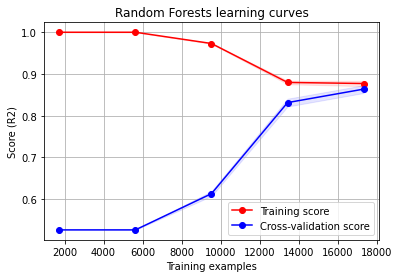

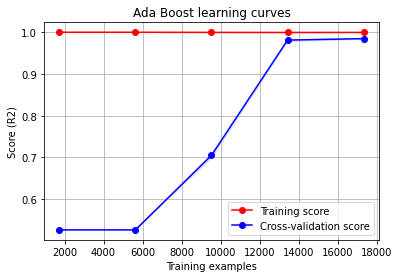

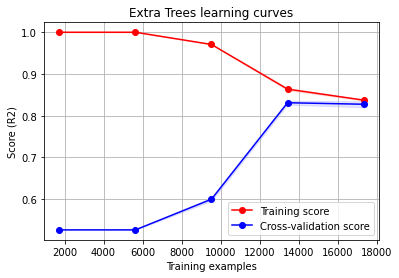

In [ ]:
mod_to_plot = ['rf', 'ab', 'xt']
info_models = {'ab': ['Ada Boost', ab_gs], 'rf': ['Random Forests', rf_gs2],
               'xt': ['Extra Trees', xt_gs]}

for mod in mod_to_plot:
  g = plot_learning_curve(info_models[mod][1].best_estimator_,
                          '{0} learning curves'.format(info_models[mod][0]), 
                          X_combined_sampling, y_combined_sampling, cv=kfold2) 

Visualizamos la importancia de las variables para predecir el estado final.


**Random Forests:**

In [ ]:
importances_rf2 = rf_best2.feature_importances_
indices_rf2 = np.argsort(importances_rf2)

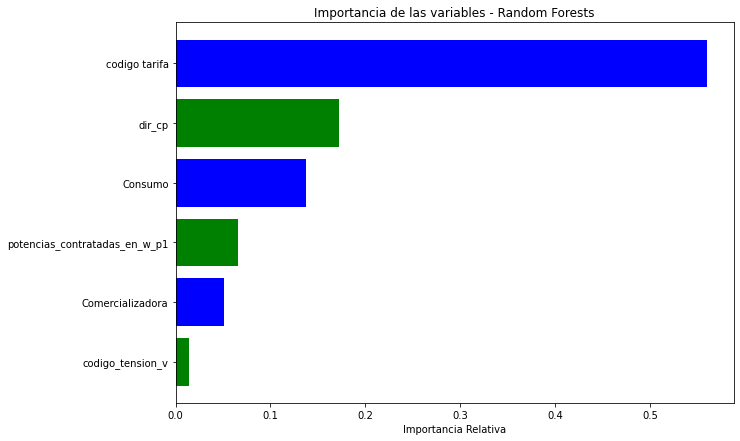

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Importancia de las variables - Random Forests')
plt.barh(range(len(indices_rf2)), importances_rf2[indices_rf2], color=['g','b'], align='center')
plt.yticks(range(len(indices_rf2)), [features_list2[i] for i in indices_rf2])
plt.xlabel('Importancia Relativa')
plt.show()

**Ada Boost:**

In [ ]:
importances_ab = ab_best.feature_importances_
indices_ab = np.argsort(importances_ab)

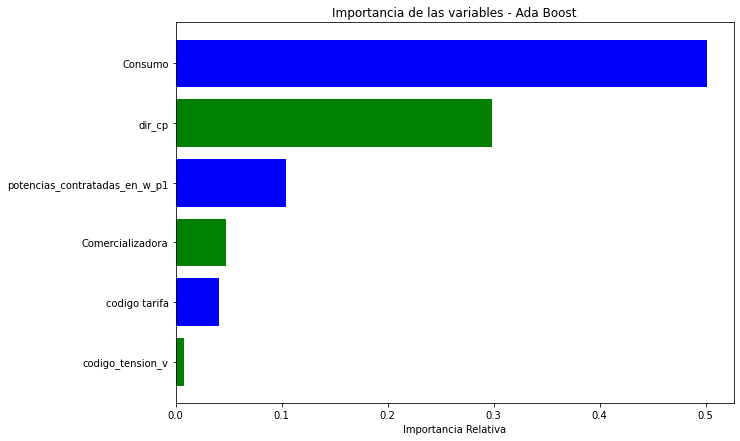

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Importancia de las variables - Ada Boost')
plt.barh(range(len(indices_ab)), importances_ab[indices_ab], color=['g','b'], align='center')
plt.yticks(range(len(indices_ab)), [features_list2[i] for i in indices_ab])
plt.xlabel('Importancia Relativa')
plt.show()

**Extra Trees**

In [ ]:
importances_xt = xt_best.feature_importances_
indices_xt = np.argsort(importances_xt)

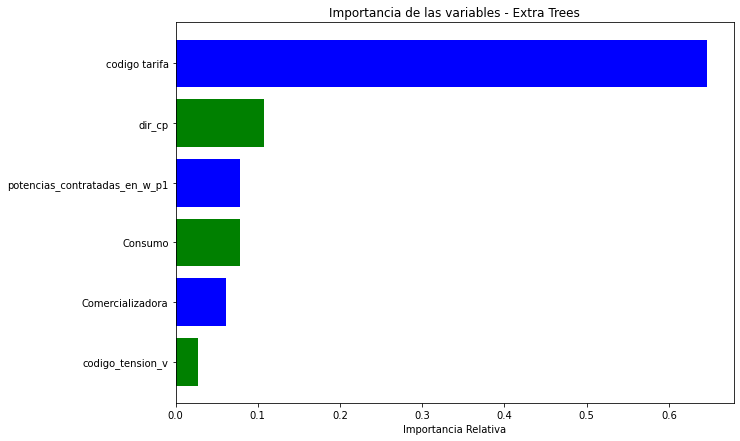

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Importancia de las variables - Extra Trees')
plt.barh(range(len(indices_xt)), importances_xt[indices_xt], color=['g','b'], align='center')
plt.yticks(range(len(indices_xt)), [features_list2[i] for i in indices_xt])
plt.xlabel('Importancia Relativa')
plt.show()

Ahora validamos haciendo las predicciones en datos del test:

In [ ]:
rf_test_pred = rf_best2.predict(X_test2)
ab_test_pred = ab_best.predict(X_test2)
xt_test_pred = xt_best.predict(X_test2)

Comprobamos el ***Classification report*** (con las principales métricas de evaluación de la predicción) para cada modelo en el *test set*:

In [ ]:
mod_to_plot = ['rf', 'ab', 'xt']
pred_models = {'ab': ['Ada Boost', ab_test_pred],
               'rf': ['Random Forests', rf_test_pred],
               'xt': ['Extra Trees', xt_test_pred]}

for mod in mod_to_plot:
  cl_report = classification_report(y_test2, pred_models[mod][1], labels=[1, 0]) 
  print(pred_models[mod][0], '\n', cl_report, '\n', '='*55)

Random Forests 
               precision    recall  f1-score   support

           1       0.11      0.69      0.19       274
           0       0.99      0.86      0.92     11335

    accuracy                           0.86     11609
   macro avg       0.55      0.78      0.55     11609
weighted avg       0.97      0.86      0.91     11609
 
Ada Boost 
               precision    recall  f1-score   support

           1       0.14      0.17      0.15       274
           0       0.98      0.97      0.98     11335

    accuracy                           0.96     11609
   macro avg       0.56      0.57      0.57     11609
weighted avg       0.96      0.96      0.96     11609
 
Extra Trees 
               precision    recall  f1-score   support

           1       0.09      0.72      0.16       274
           0       0.99      0.83      0.90     11335

    accuracy                           0.83     11609
   macro avg       0.54      0.77      0.53     11609
weighted avg       0.97      

**Matrices de confusión**: Permiten visualmente evaluar el desempeño de cada modelo para predecir la clase objetivo.

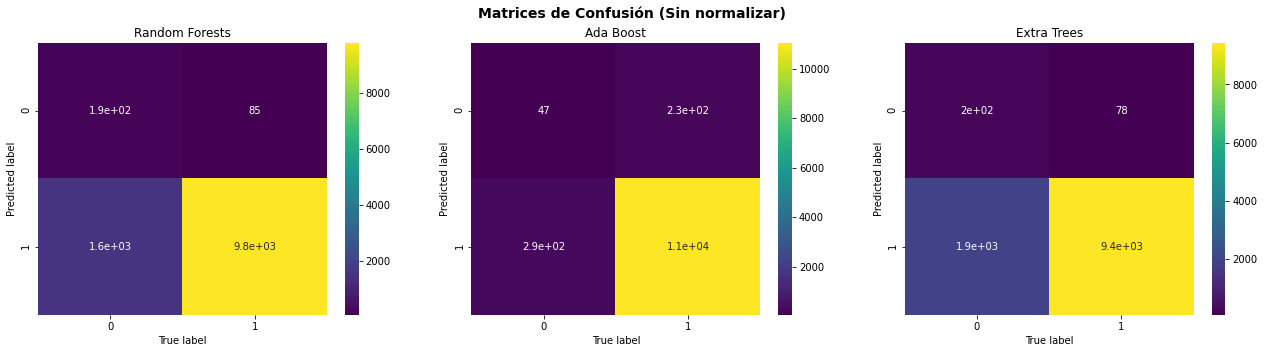

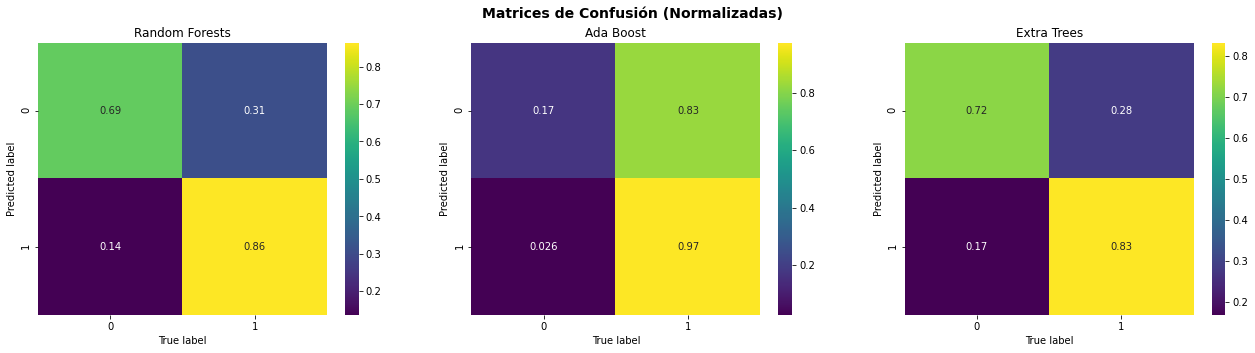

In [ ]:
fig1 = plt.figure(figsize=(22, 5))
fig1.suptitle('Matrices de Confusión (Sin normalizar)', fontsize=14, fontweight='bold')

i = 0
for mod in mod_to_plot:
    cm = confusion_matrix(y_test2, pred_models[mod][1], labels=[1, 0])
    ax = fig1.add_subplot(1, 3, 1 + i)
    plt.title(pred_models[mod][0])
    im = sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    i = i + 1
plt.show()

fig1 = plt.figure(figsize=(22, 5))
fig1.suptitle('Matrices de Confusión (Normalizadas)', fontsize=14, fontweight='bold')

i = 0
for mod in mod_to_plot:
    cm = confusion_matrix(y_test2, pred_models[mod][1], labels=[1, 0], normalize = 'true')
    ax = fig1.add_subplot(1, 3, 1 + i)
    plt.title(pred_models[mod][0])
    im = sns.heatmap(cm, annot=True, cmap='viridis', cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    i = i + 1
plt.show()

**ROC Curve**

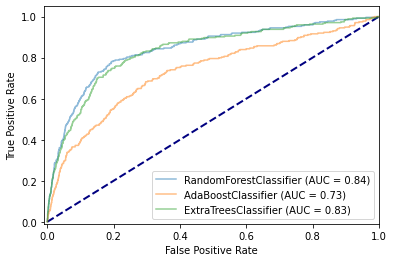

In [ ]:
rf_disp = plot_roc_curve(rf_best2, X_test2, y_test2, alpha=0.5)
ax = plt.gca()
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax.set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
ab_disp = plot_roc_curve(ab_best, X_test2, y_test2, ax=ax, alpha=0.5)
xt_disp = plot_roc_curve(xt_best, X_test2, y_test2, ax=ax, alpha=0.5)
plt.show()

Tras la evaluación de los modelos, el más idóneo para predecir si un cliente potencial terminará contratando los servicios es el **Random Forests**. Las posibles mejoras de los modelos incluirían:

- Tuning con Feature Selection. Más variables no significa mejor modelo, sino que a menudo seleccionando las variables predictoras adecuadas se puede obtener un modelo que generalice mejor.

- Search Grid más exhaustivo.

- Probar más algoritmos. 

- Modificar los *weigths* de las variables.

- Eliminar más a fondo los *outliers* de la muestra. Igualmente, probar con otros métodos de escalado.

- Se podrían combinar los modelos mediante un *VotingClassifier*, donde se tengan en cuenta las predicciones de todos los modelos.

En el [último notebook](https://github.com/rcruzgar/prediccion_clientes/blob/main/test_modelo.ipynb), cargamos el Random Forests y lo usamos para predecir el estado final de unos clientes.



---

